# Stable Diffusion notebook by [@pharmapsychotic](https://twitter.com/pharmapsychotic)

This let's you generate images with CompVis [Stable Diffusion](https://github.com/CompVis/stable-diffusion)

You need to get the ckpt file and put it on your Google Drive first to use this. It can be downloaded from [HuggingFace](https://huggingface.co/CompVis/stable-diffusion).

Check out the free [HuggingFace space for Stable Diffusion](https://huggingface.co/spaces/stabilityai/stable-diffusion)

If you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [ ]:
#@title Check GPU
!nvidia-smi -L

In [ ]:
#@title Mount Google Drive and Prepare Folders
from google.colab import drive
drive.mount('/content/gdrive')
outputs_path = "/content/gdrive/MyDrive/AI/StableDiffusion"
!mkdir -p $outputs_path
print(f"Outputs will be saved to {outputs_path}")

In [ ]:
#@title Installation
!git clone https://github.com/CompVis/stable-diffusion
%cd stable-diffusion/
!git clone https://github.com/CompVis/taming-transformers
!git clone https://github.com/openai/CLIP.git
!pip install -e ./CLIP
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install transformers
import sys
sys.path.append(".")
sys.path.append("./CLIP")
sys.path.append('./taming-transformers')

!pip install einops
!pip install kornia
!pip install omegaconf
!pip install pytorch_lightning



In [ ]:
#@markdown You need to get the model weights yourself and put on Google Drive or this Colab instance
checkpoint_model_file = "/content/gdrive/MyDrive/AI/models/sd-v1-3-full-ema.ckpt" #@param {type:"string"}

In [ ]:
#@title Setup

import argparse, gc, json, os, random, sys, time, glob, requests
import torch
import numpy as np
import PIL
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from IPython.display import display, clear_output
from itertools import islice
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from torch.cuda.amp import autocast
from torchvision.utils import make_grid
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler


def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

class config():
    def __init__(self):
        self.prompt = ""
        self.outdir = 'outputs/txt2img-samples'
        self.init_img = None
        self.ddim_steps = 100
        self.plms = True
        self.fixed_code = True
        self.ddim_eta = 0.0
        self.n_iter = 1
        self.H = 512
        self.W = 512
        self.C = 4
        self.f = 8
        self.n_samples = 1
        self.scale = 7.5
        self.strength = 0.75 # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
        self.from_file = None
        self.config = 'configs/stable-diffusion/v1-inference.yaml'
        self.ckpt = checkpoint_model_file
        self.seed = 42
        self.precision = 'full' # 'autocast'
        self.image_file = 'result.png'
      
def load_img(path, w, h):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        image = Image.open(path).convert('RGB')
    image = image.resize((w, h), Image.LANCZOS)
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

opt = config()
config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
batch_idx = 0
sample_idx = 0

def generate(opt):
    global sample_idx
    seed_everything(opt.seed)

    if opt.plms and (opt.init_img == None or opt.init_img == ''):
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    batch_size = opt.n_samples
    if not opt.from_file:
        prompt = opt.prompt
        assert prompt is not None
        data = [batch_size * [prompt]]
    else:
        print(f"reading prompts from {opt.from_file}")
        with open(opt.from_file, "r") as f:
            data = f.read().splitlines()
            data = list(chunk(data, batch_size))

    init_latent = None

    if opt.init_img != None and opt.init_img != '':
        init_image = load_img(opt.init_img, opt.W, opt.H).to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    sampler.make_schedule(ddim_num_steps=opt.ddim_steps, ddim_eta=opt.ddim_eta, verbose=False)

    assert 0. <= opt.strength <= 1., 'can only work with strength in [0.0, 1.0]'
    t_enc = int(opt.strength * opt.ddim_steps)
    print(f"target t_enc is {t_enc} steps")

    start_code = None
    if opt.fixed_code and init_latent == None:
        start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    precision_scope = autocast if opt.precision == "autocast" else nullcontext

    images = []
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                for n in range(opt.n_iter):
                    for prompts in data:
                        uc = None
                        if opt.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        if init_latent != None:
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                            samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,)
                        else:
                            shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                            samples, _ = sampler.sample(S=opt.ddim_steps,
                                                            conditioning=c,
                                                            batch_size=opt.n_samples,
                                                            shape=shape,
                                                            verbose=False,
                                                            unconditional_guidance_scale=opt.scale,
                                                            unconditional_conditioning=uc,
                                                            eta=opt.ddim_eta,
                                                            x_T=start_code)

                        x_samples = model.decode_first_stage(samples)
                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            images.append(Image.fromarray(x_sample.astype(np.uint8)))
                            filepath = os.path.join(opt.outdir, f"{batch_name}({batch_idx})_{sample_idx:04}.png")
                            print(f"Saving to {filepath}")
                            Image.fromarray(x_sample.astype(np.uint8)).save(filepath)
                            sample_idx += 1

                toc = time.time()
    return images


Used seed: 3309108090
Saved to: /content/gdrive/MyDrive/AI/StableDiffusion/20220822_Test


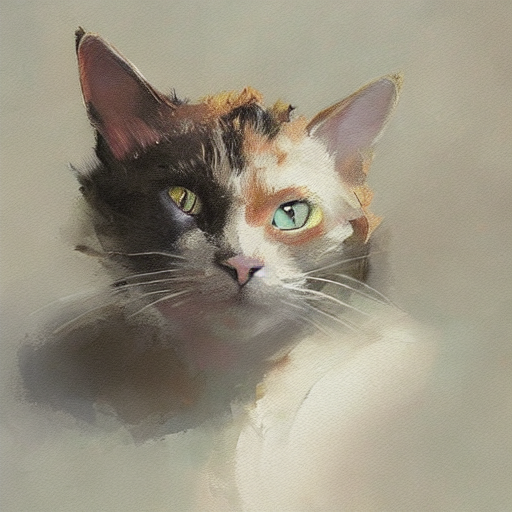

In [ ]:
#@title Image creation

#@markdown `batch_name`: name for subfolder and filenames<br>
#@markdown `width_height`: image dimensions<br>
#@markdown `guidance_scale`: strength of text prompt<br>
#@markdown `steps`: number of diffusion steps<br>
#@markdown `num_batches`: repeatedly generate images<br>
#@markdown `ddim_eta`: use 0 for PLMS sampling or up to 1.0 for DDIM<br>
#@markdown `seed`: use -1 for random seed<br>

#@markdown 

#@markdown Batch settings
batch_name = "20220822_Test" #@param {type:"string"}
width_height = [512, 512] #@param{type: 'raw'}
guidance_scale = 7.5 #@param {type:"number"}
steps = 100 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
num_batches = 1 #@param {type:"integer"}
ddim_eta = 0 #@param {type:"number"}
seed = -1 #@param {type:"integer"}

#@markdown 

#@markdown Init image
init_image = "" #@param {type:"string"}
init_strength = 0 #@param {type:"number"}

#@markdown 

#@markdown Prompt
prompt = "a detailed painting of a cat by Greg Rutkowski" #@param {type:"string"}


opt.init_img = init_image
opt.n_samples = samples_per_batch
opt.scale = guidance_scale
opt.ddim_steps = steps
opt.n_iter = 1
opt.prompt = prompt
opt.strength = 1.0 - init_strength
opt.outdir = os.path.join(outputs_path, batch_name)
opt.image_file = batch_name
opt.W = width_height[0]
opt.H = width_height[1]
opt.seed = random.randint(0, 2**32) if seed == -1 else seed

if opt.strength >= 1 or init_image == None:
    opt.init_img = ""

if ddim_eta > 0:
    opt.ddim_eta = ddim_eta
    opt.plms = False
else:
    opt.ddim_eta = 0.0
    opt.plms = True


# save settings
settings = {
    'prompt': prompt,
    'width': opt.W,
    'height': opt.H,
    'num_batches': num_batches,
    'samples_per_batch': samples_per_batch,
    'seed': opt.seed,
    'steps': steps,
    'guidance_scale': guidance_scale,
    'ddim_eta': ddim_eta,
    'init_image': init_image,
    'init_strength': init_strength
}
os.makedirs(opt.outdir, exist_ok=True)
while os.path.isfile(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt"):
    batch_idx += 1
with open(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt", "w+", encoding="utf-8") as f:
    json.dump(settings, f, ensure_ascii=False, indent=4)
sample_idx = 0

for i in range(num_batches):
    gc.collect()
    torch.cuda.empty_cache()

    images = generate(opt)

    clear_output(wait=True)
    print(f"Used seed: {opt.seed}")
    print(f"Saved to: {opt.outdir}")
    for image in images:
        display(image)

    opt.seed += 1
